### Pokemon statistics

Note the data includes Pokemon up to Generation 6. BST stands for 'Base Stat Total', so the sum of the individual stats (HP, Attack, Special Attack, Defense, Special Defense, Speed).

We answer the following questions:
1. Which three types appear the most, and the least?
2. Which type combinations do not exist?
3. Which types appear the most when only looking at the strongest and weakest Pokemon (based on BST)?
4. Which types appear the most based on each of the individual stats?
5. Does the average BST change with Generation?
6. Is the BST of Legendaries significantly different from non-Legendaries?
7. Is there a relation between BST and the first letter of Pokemon names?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy.optimize import curve_fit

In [2]:
data = pd.read_csv('../data/poke_data/Pokemon.csv')
data.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


#### 1. Which three types appear the most, and the least?

Most common:
 Water     126
Normal    102
Flying    101
Name: count, dtype: int64

Least common:
 Ghost    46
Fairy    40
Ice      38
Name: count, dtype: int64


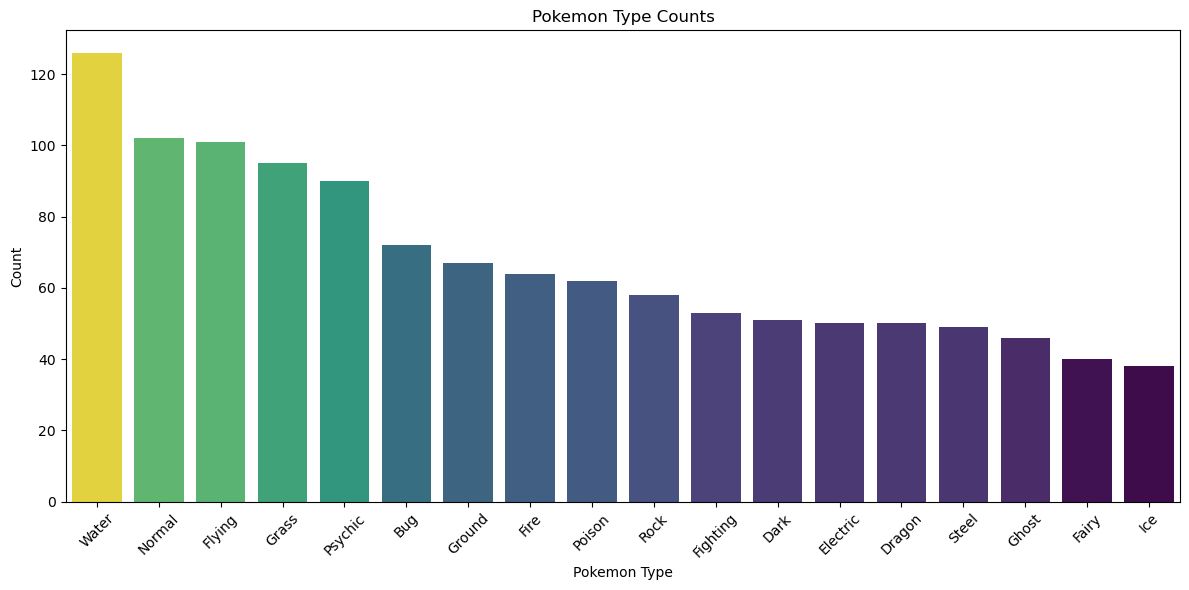

In [3]:
# We will count both the first and second type independently
type_counts = pd.concat([data['Type 1'], data['Type 2']]).value_counts()
# Print the first and last 3 types
print('Most common:\n', type_counts.head(3))
print()
print('Least common:\n', type_counts.tail(3))

# Barplot
plt.figure(figsize=(12, 6))
sns.barplot(x=type_counts.index, y=type_counts.values, hue=type_counts.values, palette='viridis', legend=False)
plt.xticks(rotation=45)
plt.title('Pokemon Type Counts')
plt.xlabel('Pokemon Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

There are a lot of fish, but few things made of ice.

#### 2. Which type combinations do not exist?

In [4]:
# First filter out the single type Pokémon
double_type_data = data[data['Type 2'].notnull()]

# Get the double types, use size() as you need something to aggregate, and reset the index to get a DataFrame
double_types = double_type_data.groupby(['Type 1', 'Type 2']).size().reset_index()[['Type 1', 'Type 2']]
double_types

,Type 1,Type 2
0,Bug,Electric
1,Bug,Fighting
2,Bug,Fire
3,Bug,Flying
4,Bug,Ghost
...,...,...
131,Water,Ice
132,Water,Poison
133,Water,Psychic
134,Water,Rock


In [5]:
# Now these may be in any order, like both Water/Grass and Grass/Water appear, but we want to count them as the same
# So make tuples of types and add them to a list; if it or the inverse is already in the list, leave it out
double_type_tuples = []
for row in double_types.itertuples(index=False):
    t1, t2 = row
    if ((t1, t2) not in double_type_tuples) and ((t2, t1) not in double_type_tuples):
        double_type_tuples.append((t1, t2))
print('Double types:', double_type_tuples)
N_doubles = len(double_type_tuples)
print('Number of unique double types in the data:', N_doubles)

Double types: [('Bug', 'Electric'), ('Bug', 'Fighting'), ('Bug', 'Fire'), ('Bug', 'Flying'), ('Bug', 'Ghost'), ('Bug', 'Grass'), ('Bug', 'Ground'), ('Bug', 'Poison'), ('Bug', 'Rock'), ('Bug', 'Steel'), ('Bug', 'Water'), ('Dark', 'Dragon'), ('Dark', 'Fighting'), ('Dark', 'Fire'), ('Dark', 'Flying'), ('Dark', 'Ghost'), ('Dark', 'Ice'), ('Dark', 'Psychic'), ('Dark', 'Steel'), ('Dragon', 'Electric'), ('Dragon', 'Fairy'), ('Dragon', 'Fire'), ('Dragon', 'Flying'), ('Dragon', 'Ground'), ('Dragon', 'Ice'), ('Dragon', 'Psychic'), ('Electric', 'Fairy'), ('Electric', 'Fire'), ('Electric', 'Flying'), ('Electric', 'Ghost'), ('Electric', 'Grass'), ('Electric', 'Ice'), ('Electric', 'Normal'), ('Electric', 'Steel'), ('Electric', 'Water'), ('Fairy', 'Flying'), ('Fighting', 'Flying'), ('Fighting', 'Psychic'), ('Fighting', 'Steel'), ('Fire', 'Fighting'), ('Fire', 'Flying'), ('Fire', 'Ground'), ('Fire', 'Normal'), ('Fire', 'Psychic'), ('Fire', 'Rock'), ('Fire', 'Steel'), ('Fire', 'Water'), ('Ghost', 'Drag

In [6]:
# Now determine how many unique combinations there are possible
# Get a list of all unique types
types = data['Type 1'].unique()  # each type for sure appears at least once
N_types = len(types)

# The number of combinations is given by the sum of N from 1 to N-1
N_combinations = 0
for i in range(1, N_types):
    N_combinations += i
print(f'There are {N_types} unique types and {N_combinations} possible type combinations.')

There are 18 unique types and 153 possible type combinations.


In [7]:
# We see there are less types actually in the data than possible combinations, so indeed some combinations do not exist
# To find these, determine if each possible combination is in the double_type_tuples list
N_missing = 0
for i in range(N_types):
    for j in range(i+1, N_types):
        t1, t2 = types[i], types[j]
        if ((t1, t2) in double_type_tuples) or ((t2, t1) in double_type_tuples):
            pass
        else:
            print(f'Combination {t1}/{t2} does not exist in the data.')
            N_missing += 1
print(N_missing, 'The calculations are consistent:', N_combinations-N_doubles==N_missing)

Combination Grass/Fire does not exist in the data.
Combination Fire/Poison does not exist in the data.
Combination Fire/Fairy does not exist in the data.
Combination Fire/Ice does not exist in the data.
Combination Bug/Normal does not exist in the data.
Combination Bug/Fairy does not exist in the data.
Combination Bug/Psychic does not exist in the data.
Combination Bug/Ice does not exist in the data.
Combination Bug/Dragon does not exist in the data.
Combination Bug/Dark does not exist in the data.
Combination Normal/Poison does not exist in the data.
Combination Normal/Rock does not exist in the data.
Combination Normal/Ghost does not exist in the data.
Combination Normal/Ice does not exist in the data.
Combination Normal/Dragon does not exist in the data.
Combination Normal/Dark does not exist in the data.
Combination Normal/Steel does not exist in the data.
Combination Poison/Electric does not exist in the data.
Combination Poison/Fairy does not exist in the data.
Combination Poison

Some of these missing ones make sense, like a Fire/Ice type, although the concept is interesting.

#### 3. Which types appear the most when only looking at the strongest (BST>500 or so) and weakest (BST<300 or so) Pokemon?

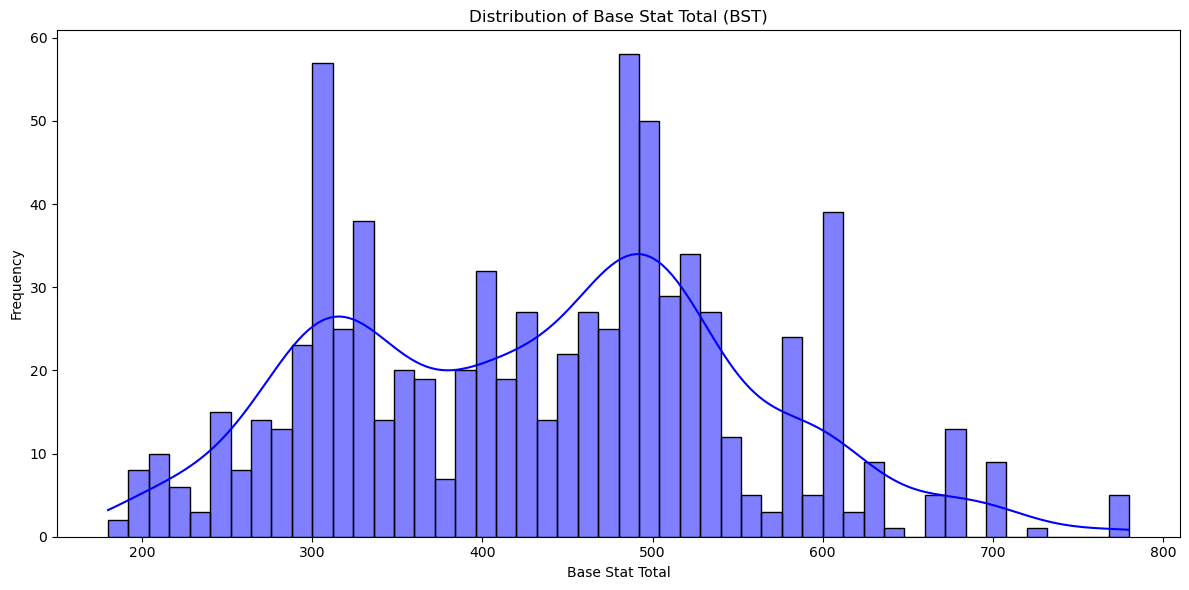

In [8]:
# First look at the BST distribution to set a reasonable range for high and low values
BST = data['Total']
plt.figure(figsize=(12, 6))
sns.histplot(BST, bins=50, kde=True, color='blue')
plt.title('Distribution of Base Stat Total (BST)')
plt.xlabel('Base Stat Total')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [9]:
# Based on this, cutoffs at 300 and 550 seem reasonable for low and high BST
# Check percentages
low_BST_count = (BST < 300).sum()
high_BST_count = (BST > 550).sum()
total_count = len(BST)
print(f'Percentage of Pokémon with low BST (< 300): {low_BST_count / total_count * 100:.2f}%')
print(f'Percentage of Pokémon with high BST (> 550): {high_BST_count / total_count * 100:.2f}%')

Percentage of Pokémon with low BST (< 300): 12.75%
Percentage of Pokémon with high BST (> 550): 15.25%


In [10]:
# Sidenote: check who the strongest and weakest Pokémon are
data_BST_sorted = data.sort_values(by='Total', ascending=False)
print('Strongest Pokémon:\n', data_BST_sorted[['Name', 'Total']].head())
print()
print('Weakest Pokémon:\n', data_BST_sorted[['Name', 'Total']].tail())

Strongest Pokémon:
                       Name  Total
426  RayquazaMega Rayquaza    780
164    MewtwoMega Mewtwo Y    780
163    MewtwoMega Mewtwo X    780
422    KyogrePrimal Kyogre    770
424  GroudonPrimal Groudon    770

Weakest Pokémon:
           Name  Total
13    Caterpie    195
288    Wurmple    195
446  Kricketot    194
322    Azurill    190
206    Sunkern    180


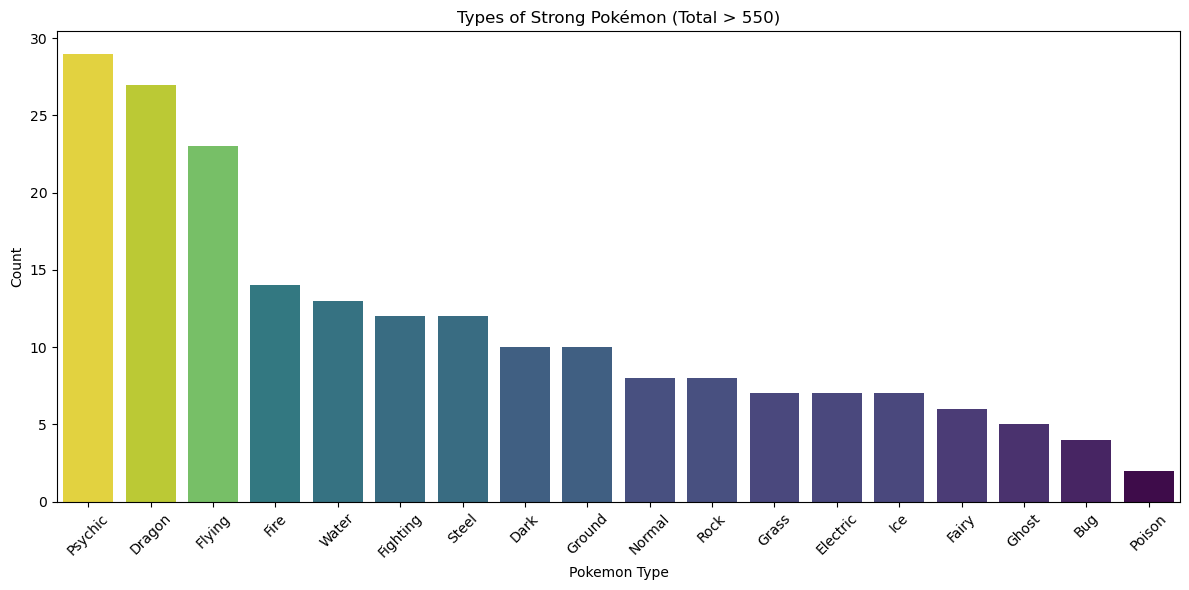

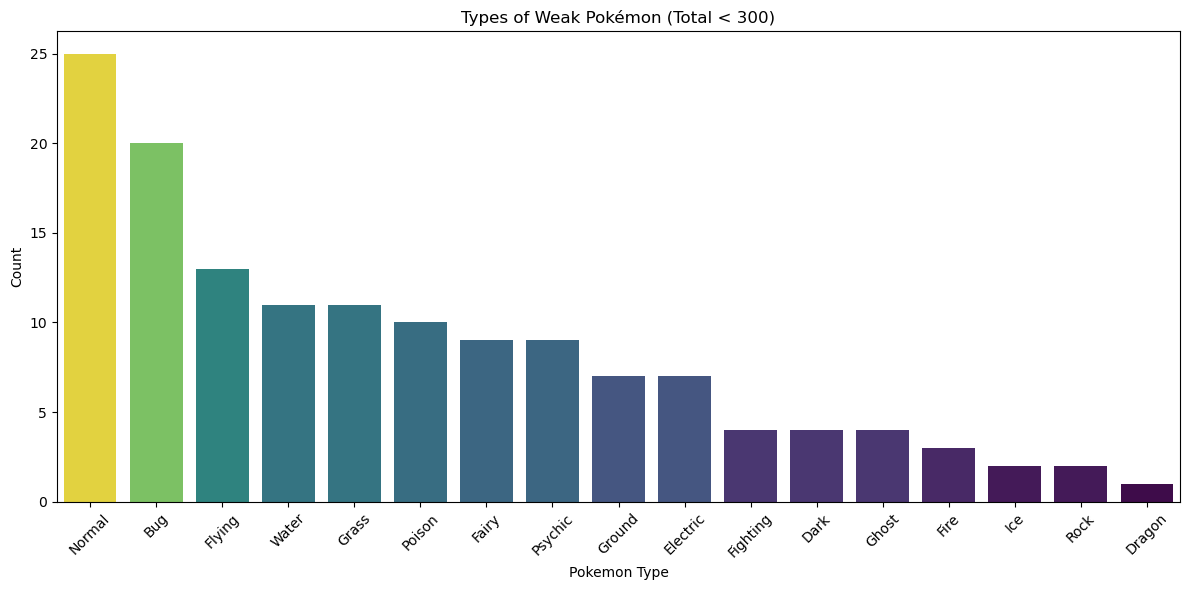

In [11]:
# Now see which types appear most in the strongest and weakest Pokémon
data_strong = data[data['Total'] > 550]
data_weak = data[data['Total'] < 300]

type_counts_strong = pd.concat([data_strong['Type 1'], data_strong['Type 2']]).value_counts()
type_counts_weak = pd.concat([data_weak['Type 1'], data_weak['Type 2']]).value_counts()

# Barplot for strong Pokémon types
plt.figure(figsize=(12, 6))
sns.barplot(x=type_counts_strong.index, y=type_counts_strong.values, hue=type_counts_strong.values, palette='viridis', legend=False)
plt.xticks(rotation=45)
plt.title('Types of Strong Pokémon (Total > 550)')
plt.xlabel('Pokemon Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Barplot for weak Pokémon types
plt.figure(figsize=(12, 6))
sns.barplot(x=type_counts_weak.index, y=type_counts_weak.values, hue=type_counts_weak.values, palette='viridis', legend=False)
plt.xticks(rotation=45)
plt.title('Types of Weak Pokémon (Total < 300)')
plt.xlabel('Pokemon Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

It is clear these distributions are different from all Pokemon we saw before. Stronger Pokemon include relatively many Psychic, Dragon and Flying types and few Poison, Bug and Ghost types. Weaker ones include many Normal, Bug and (again) Flying types and few Dragon, Rock and Ice types; on top of that, there are 0 weak Steel types, which is missing in that plot!

We could also account for the fact that some types do not appear as often in general, so we divide the counts by how often each appears for all BST.
(E.g. there are few Ice types in total, so you are bound to also find few strong/weak Ice types, but maybe there are relatively more strong/weak Ice types in the subset.)

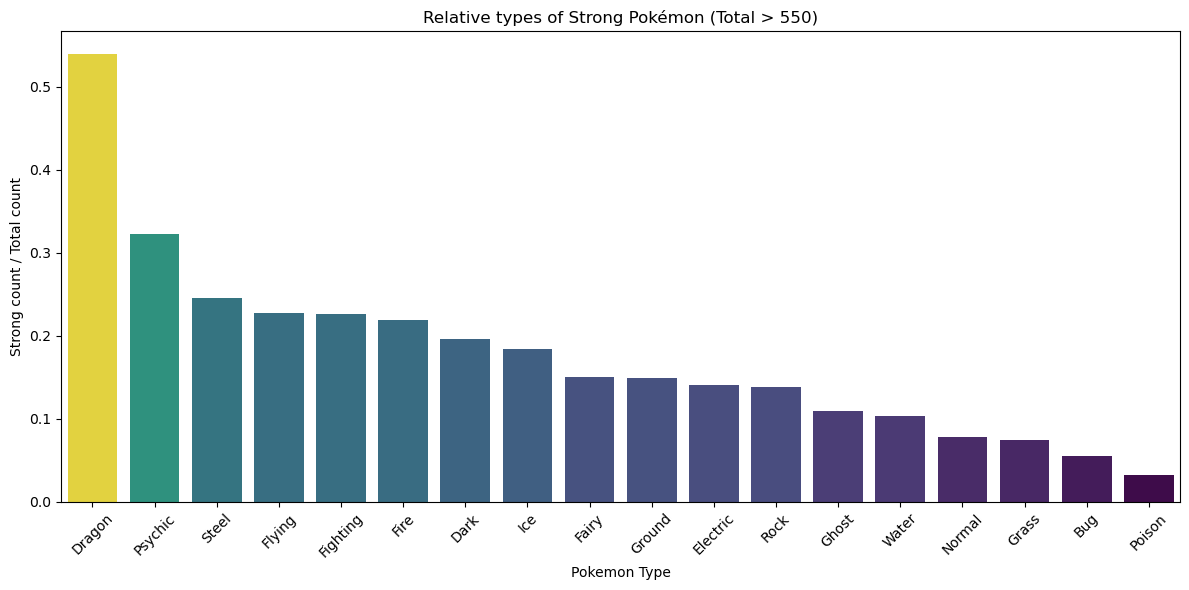

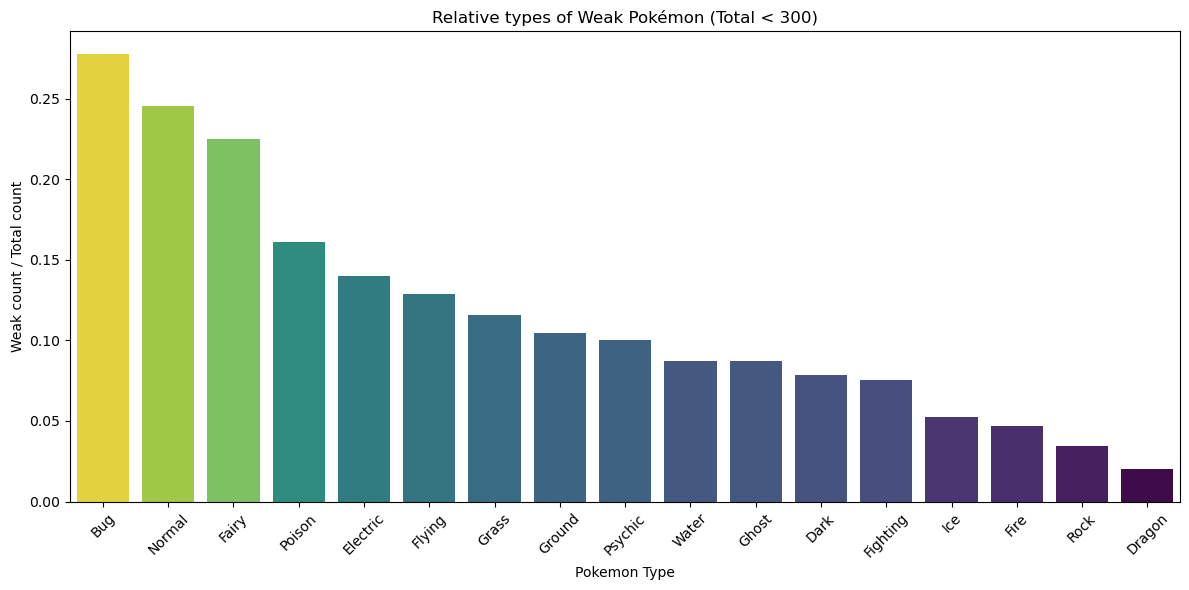

In [12]:
type_counts_strong_norm = type_counts_strong / type_counts  # note this automatically matches the indices
type_counts_strong_norm.sort_values(ascending=False, inplace=True)
type_counts_weak_norm = type_counts_weak / type_counts
type_counts_weak_norm.sort_values(ascending=False, inplace=True)
# Drop Steel, which is not in the weak Pokémon
type_counts_weak_norm = type_counts_weak_norm.drop('Steel', errors='ignore')

# Barplot for strong Pokémon types
plt.figure(figsize=(12, 6))
sns.barplot(x=type_counts_strong_norm.index, y=type_counts_strong_norm.values, hue=type_counts_strong_norm.values, palette='viridis', legend=False)
plt.xticks(rotation=45)
plt.title('Relative types of Strong Pokémon (Total > 550)')
plt.xlabel('Pokemon Type')
plt.ylabel('Strong count / Total count')
plt.tight_layout()
plt.show()

# Barplot for weak Pokémon types
plt.figure(figsize=(12, 6))
sns.barplot(x=type_counts_weak_norm.index, y=type_counts_weak_norm.values, hue=type_counts_weak_norm.values, palette='viridis', legend=False)
plt.xticks(rotation=45)
plt.title('Relative types of Weak Pokémon (Total < 300)')
plt.xlabel('Pokemon Type')
plt.ylabel('Weak count / Total count')
plt.tight_layout()
plt.show()

Now you see Dragon types are more often strong, and Psychic types less often, as there are more Psychic and less Dragon types in total. Poison and Bug types are still not often strong though. And for weak Pokemon, Bug and Normal types also switched places.

#### 4. Which types appear the most based on each of the individual stats?

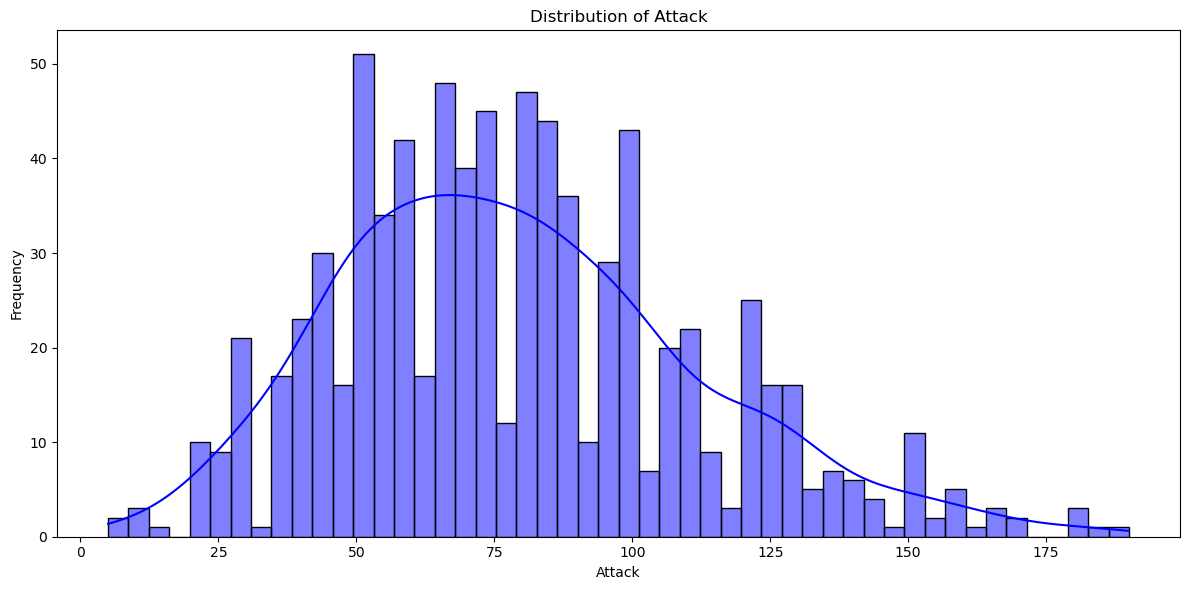

In [13]:
# So we essentially do the same as before, but now for separate stats instead of the total
def plot_stat_distribution(stat_name):
    plt.figure(figsize=(12, 6))
    sns.histplot(data[stat_name], bins=50, kde=True, color='blue')
    plt.title(f'Distribution of {stat_name}')
    plt.xlabel(stat_name)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# We'll just look at Attack and Defense as examples, first Attack
plot_stat_distribution('Attack')

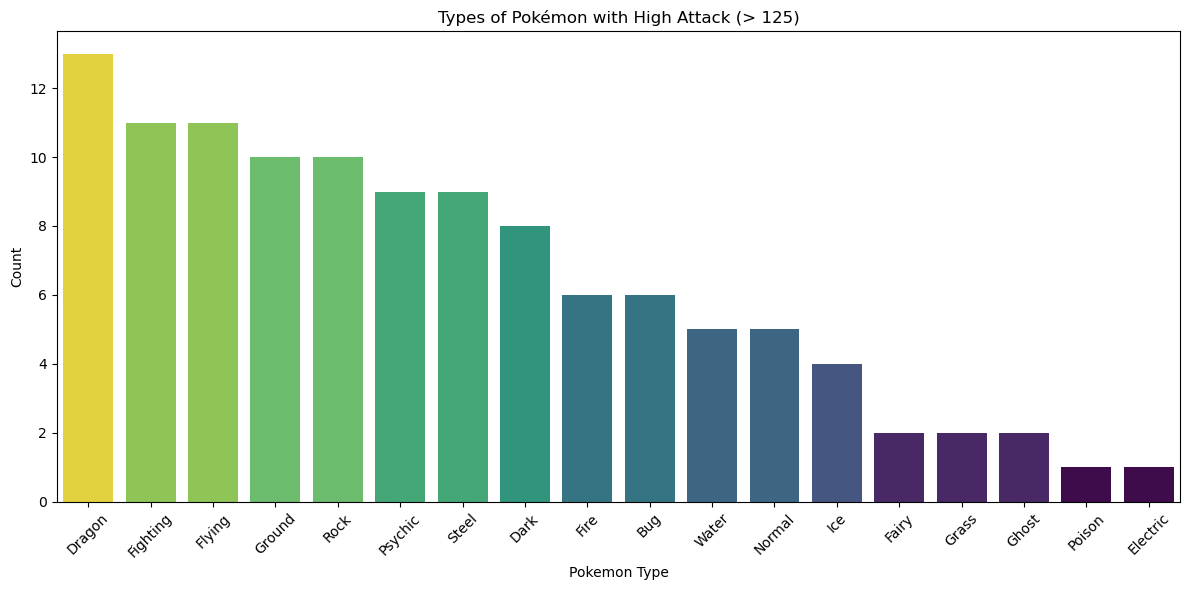

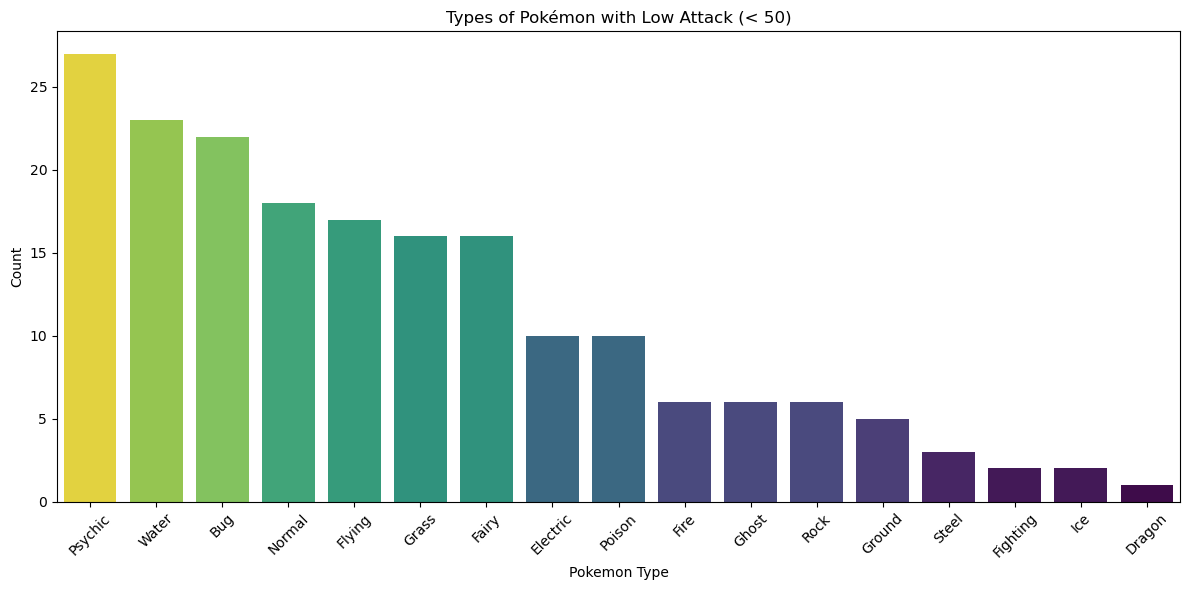

In [14]:
# Say cutoffs at 50 and 125
def find_high_low_counts(stat_name, low_cutoff, high_cutoff):
    data_high = data[data[stat_name] > high_cutoff]
    data_low = data[data[stat_name] < low_cutoff]

    high_counts = pd.concat([data_high['Type 1'], data_high['Type 2']]).value_counts()
    low_counts = pd.concat([data_low['Type 1'], data_low['Type 2']]).value_counts()

    # Barplots
    plt.figure(figsize=(12, 6))
    sns.barplot(x=high_counts.index, y=high_counts.values, hue=high_counts.values, palette='viridis', legend=False)
    plt.xticks(rotation=45)
    plt.title(f'Types of Pokémon with High {stat_name} (> {high_cutoff})')
    plt.xlabel('Pokemon Type')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(x=low_counts.index, y=low_counts.values, hue=low_counts.values, palette='viridis', legend=False)
    plt.xticks(rotation=45)
    plt.title(f'Types of Pokémon with Low {stat_name} (< {low_cutoff})')
    plt.xlabel('Pokemon Type')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

find_high_low_counts('Attack', 50, 125)

So Dragon types often have high attack, just like they have high BST. But types like Fighting seem more specialized on the Attack stat, as their total stats are not often as high. And e.g. Psychic types have low Attack while they do have high total stats, indicating they are often specialized in a different stat.

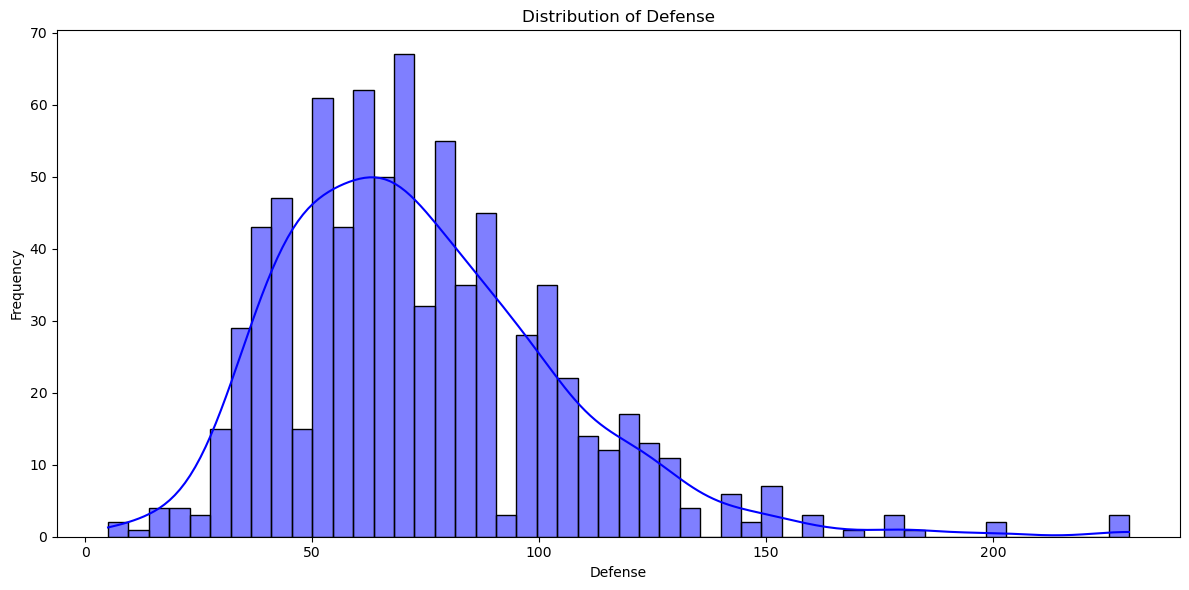

In [15]:
# For Defense
plot_stat_distribution('Defense')

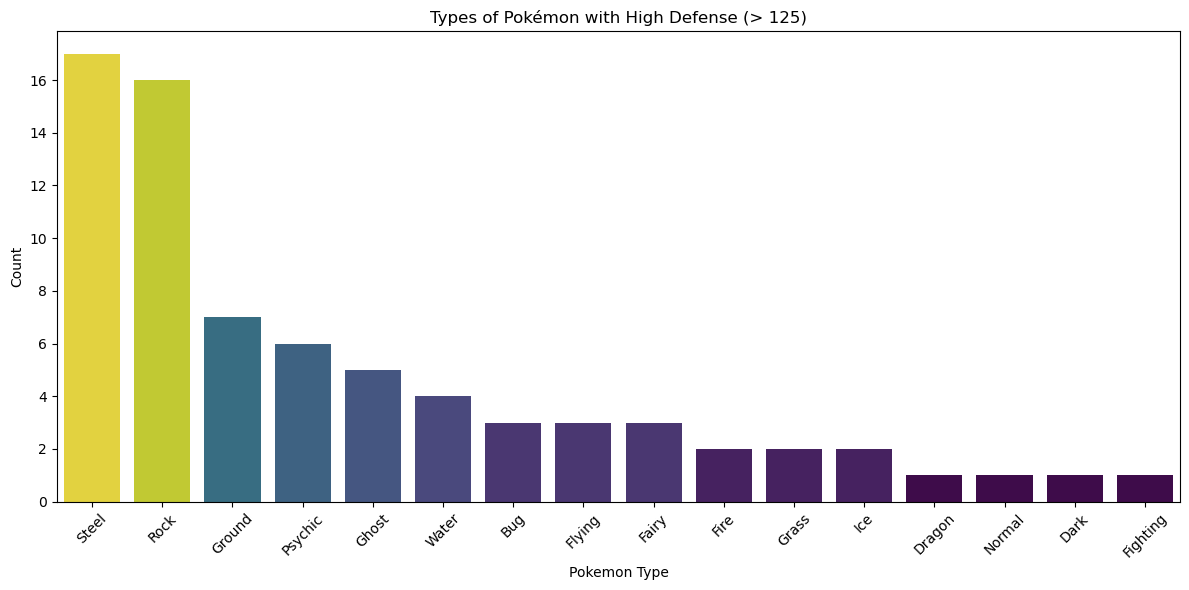

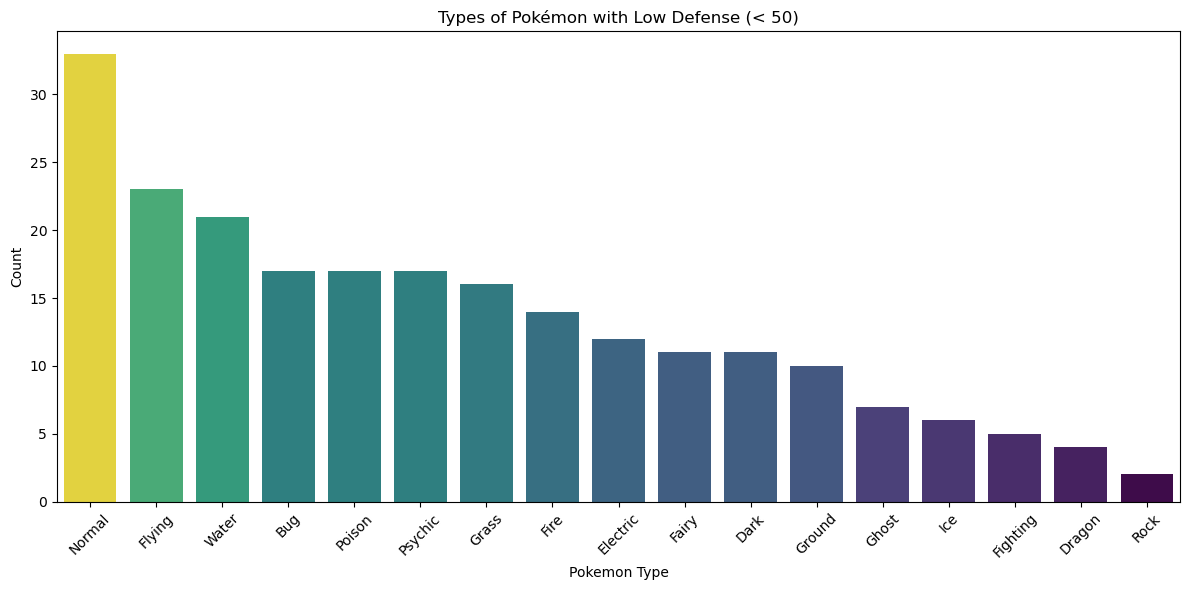

In [16]:
find_high_low_counts('Defense', 50, 125)

We see Steel and Rock types often have very high defenses, which makes sense, while Normal types have low Defense.

#### 5. Does the average BST change with Generation?

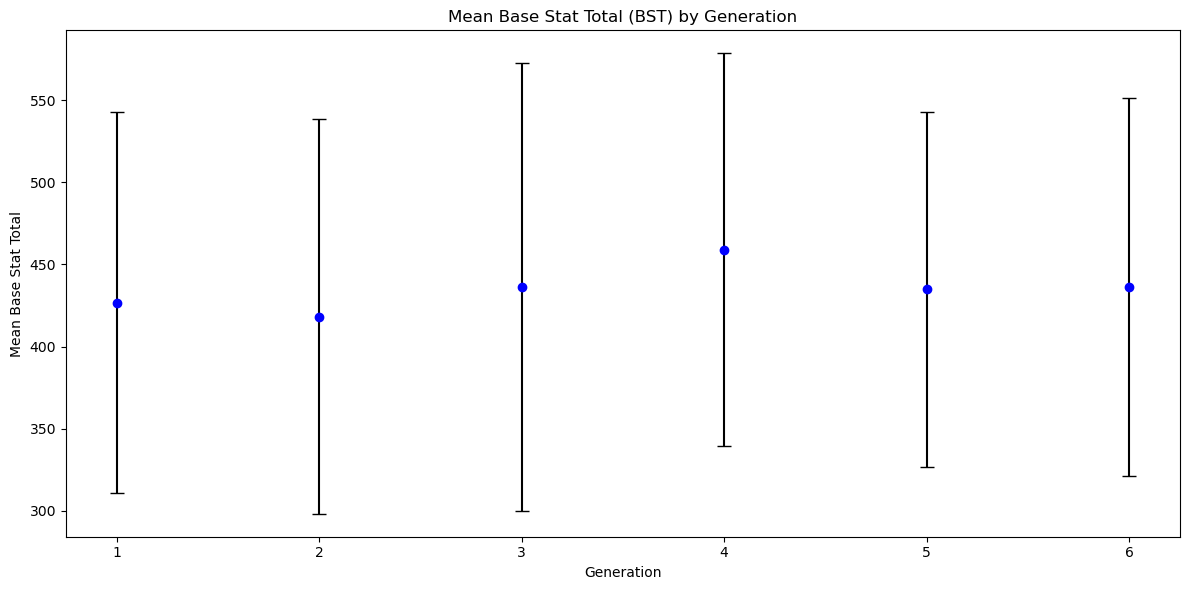

In [17]:
mean_BST_gen = data.groupby('Generation')['Total'].mean()
std_BST_gen = data.groupby('Generation')['Total'].std()

plt.figure(figsize=(12, 6))
plt.errorbar(mean_BST_gen.index, mean_BST_gen.values, yerr=std_BST_gen.values, fmt='o', capsize=5, color='blue', ecolor='black')
plt.title('Mean Base Stat Total (BST) by Generation')
plt.xlabel('Generation')
plt.ylabel('Mean Base Stat Total')
plt.xticks(mean_BST_gen.index)
plt.tight_layout()
plt.show()

In [18]:
# There is some difference visible, but it does not seem statistically significant
# Look at e.g. Gen 2 and 4; because the stats are not normally distributed, we use the Mann-Whitney U test
gen2_BST = data[data['Generation'] == 2]['Total']
gen4_BST = data[data['Generation'] == 4]['Total']
statistic, p_value = mannwhitneyu(gen2_BST, gen4_BST, alternative='two-sided')
print(f'Mann-Whitney U test statistic: {statistic}, p-value: {p_value}')

Mann-Whitney U test statistic: 5130.5, p-value: 0.009383358210779904


Despite the large standard deviation, the small p-value indicates there is a significant difference between Gen 2 and 4 at least, so we can try to fit a line to the data and check its slope.

Fitted parameters: a = 3.286883476775803 ± 3.1053168205094317, b = 423.4131881879121 ± 12.383101645303709


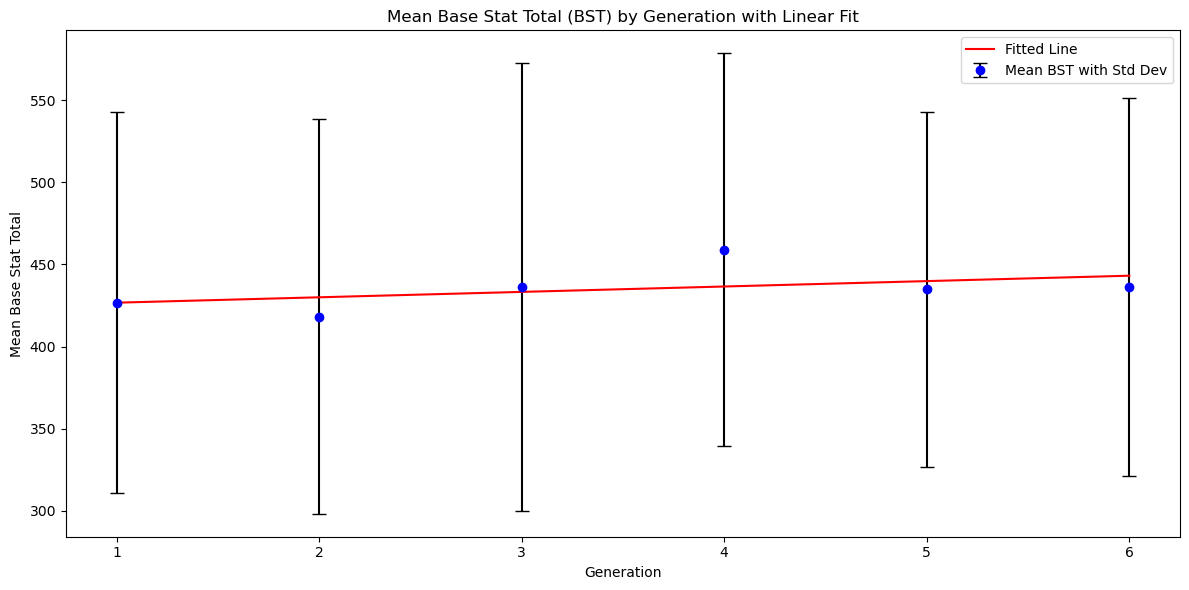

In [19]:
def linear_fit(x, a, b):
    return a * x + b

popt, pcov = curve_fit(linear_fit, mean_BST_gen.index,  mean_BST_gen.values, sigma=std_BST_gen.values)
errors = np.sqrt(np.diag(pcov))
print(f'Fitted parameters: a = {popt[0]} ± {errors[0]}, b = {popt[1]} ± {errors[1]}')
fitted_line = linear_fit(mean_BST_gen.index, *popt)

plt.figure(figsize=(12, 6))
plt.errorbar(mean_BST_gen.index, mean_BST_gen.values, yerr=std_BST_gen.values, fmt='o', capsize=5, color='blue', ecolor='black', label='Mean BST with Std Dev')
plt.plot(mean_BST_gen.index, fitted_line, color='red', label='Fitted Line')
plt.title('Mean Base Stat Total (BST) by Generation with Linear Fit')
plt.xlabel('Generation')
plt.ylabel('Mean Base Stat Total')
plt.xticks(mean_BST_gen.index)
plt.legend()
plt.tight_layout()
plt.show()

In this fit we get a slope of about 3, indicating there is a small rise in BST each generation. However, its standard deviation is about 3 too, so it is not very certain.

Additionally, this fit might be influenced by the BST's in Gen 2 and 4, which appear to be relatively far from the fitted line. This is likely because Gen 2 introduced a bunch of 'Baby Pokemon', new first-stage evolutions to Pokemon that already existed in Gen 1, and as the name suggests these Baby Pokemon are not very strong and have a low BST (but they are quite cute). On the other hand, Gen 4 introduced a number of new third-stage evolutions to existing Pokemon, which do have higher stats, increasing the mean BST. (For example, Gen 2 got Magby, while Gen 4 got Magmortar.)

So let's also see what happens if we drop Gen 2 and 4.

Fitted parameters (without Gen 2 and 4): a = 1.7252150209421808 ± 0.7519765684061654, b = 426.817923618702 ± 3.2542021272187336


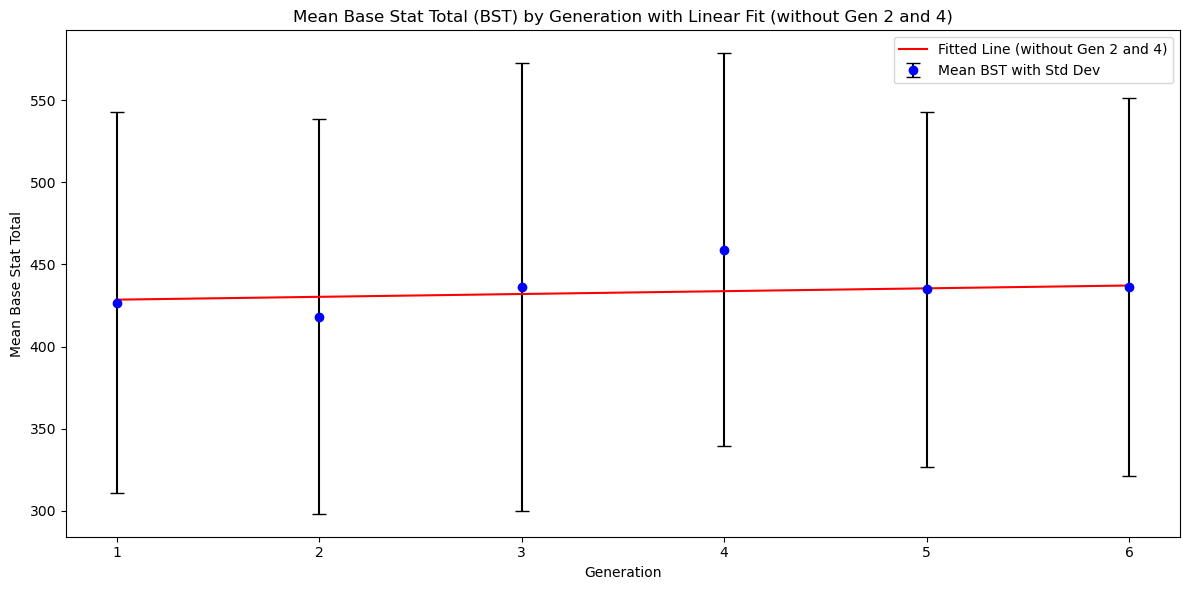

In [20]:
mean_BST_gen_drop = mean_BST_gen.drop([2, 4])
std_BST_gen_drop = std_BST_gen.drop([2, 4])

popt_drop, pcov_drop = curve_fit(linear_fit, mean_BST_gen_drop.index, mean_BST_gen_drop.values, sigma=std_BST_gen_drop.values)
errors_drop = np.sqrt(np.diag(pcov_drop))
print(f'Fitted parameters (without Gen 2 and 4): a = {popt_drop[0]} ± {errors_drop[0]}, b = {popt_drop[1]} ± {errors_drop[1]}')
fitted_line_drop = linear_fit(mean_BST_gen_drop.index, *popt_drop)
plt.figure(figsize=(12, 6))
plt.errorbar(mean_BST_gen.index, mean_BST_gen.values, yerr=std_BST_gen.values, fmt='o', capsize=5, color='blue', ecolor='black', label='Mean BST with Std Dev')
plt.plot(mean_BST_gen_drop.index, fitted_line_drop, color='red', label='Fitted Line (without Gen 2 and 4)')
plt.title('Mean Base Stat Total (BST) by Generation with Linear Fit (without Gen 2 and 4)')
plt.xlabel('Generation')
plt.ylabel('Mean Base Stat Total')
plt.xticks(mean_BST_gen.index)
plt.legend()
plt.tight_layout()
plt.show()

Now the slope is only about 2 and also has a smaller standard deviation. Still, there does not seem to be any large increase in stats with each Generation.

#### 6. Is the BST of Legendaries significantly different from non-Legendaries?

In [25]:
mean_BST_legend = data.groupby('Legendary')['Total'].mean()
std_BST_legend = data.groupby('Legendary')['Total'].std()
print('Mean Base Stat Total (BST) for Legendary Pokémon:')
print(mean_BST_legend.loc[True], '±', std_BST_legend.loc[True])
print('Mean Base Stat Total (BST) for Non-Legendary Pokémon:')
print(mean_BST_legend.loc[False], '±', std_BST_legend.loc[False])

Mean Base Stat Total (BST) for Legendary Pokémon:
637.3846153846154 ± 60.937389053153446
Mean Base Stat Total (BST) for Non-Legendary Pokémon:
417.21360544217686 ± 106.76041745713007


In [27]:
# Significance test, again using the Mann-Whitney U test, if Legendary Pokémon have significantly higher BST than non-Legendary Pokémon
legendary_BST = data[data['Legendary'] == True]['Total']
non_legendary_BST = data[data['Legendary'] == False]['Total']
statistic, p_value = mannwhitneyu(legendary_BST, non_legendary_BST, alternative='greater')
print(f'Mann-Whitney U test statistic: {statistic}, p-value: {p_value}')

Mann-Whitney U test statistic: 46289.5, p-value: 2.084630409563061e-36


So Legendaries indeed have much higher stats, as one would expect.

#### 7. Is there a relation between BST and the first letter of Pokemon names?

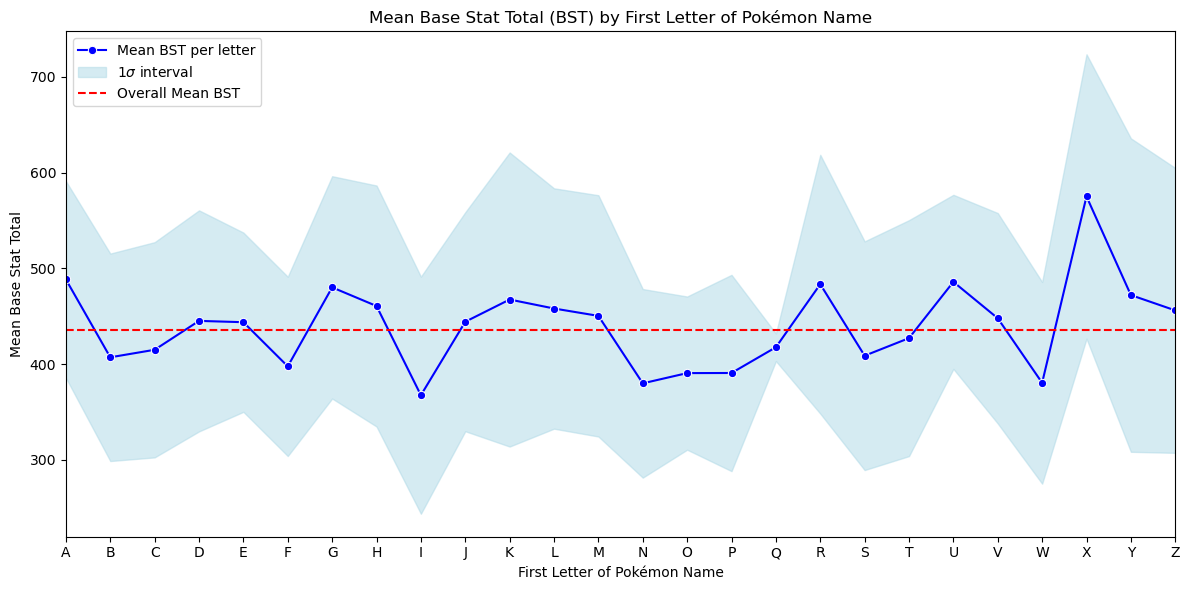

In [53]:
# Add a first letter column
data['First Letter'] = data['Name'].str[0].str.upper()
mean_BST_letter = data.groupby('First Letter')['Total'].mean()
std_BST_letter = data.groupby('First Letter')['Total'].std()
overall_mean = data['Total'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=mean_BST_letter.index, y=mean_BST_letter.values, marker='o', color='blue', label='Mean BST per letter')
plt.fill_between(mean_BST_letter.index, mean_BST_letter - std_BST_letter, mean_BST_letter + std_BST_letter, color='lightblue', alpha=0.5, label=r'1$\sigma$ interval')
plt.axhline(overall_mean, color='red', linestyle='--', label='Overall Mean BST')
plt.title('Mean Base Stat Total (BST) by First Letter of Pokémon Name')
plt.xlabel('First Letter of Pokémon Name')
plt.ylabel('Mean Base Stat Total')
plt.xlim(mean_BST_letter.index.min(), mean_BST_letter.index.max())
plt.legend()
plt.tight_layout()
plt.show()

So as one could reasonably suspect, there is no relation visible between the first letter and BST. The peak at 'X' is interesting; this is caused by there only being two Pokemon with an X (Xatu and Xerneas), one of which is a Legendary, so that the BST has a large random spike there.